<a href="/assets/tutorial04_example.ipynb" class="link-button">Download</a>
<a href="https://colab.research.google.com/github/technion046195/technion046195/blob/master/content/tutorial04/example.ipynb" target="_blank">
<img src="../assets/colab-badge.svg" style="display:inline"/>
</a>

<center><h1>
תרגול 4 - דוגמא מעשית
</h1></center>

## Setup

In [ ]:
## Importing packages
import os # A build in package for interacting with the OS. For example to create a folder.
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package
import imageio  # A package to read and write image (is used here to save gif images)

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (4.5, 4.5)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations, pandas tables and images in cells output
from IPython.core.display import display, HTML, Latex, Markdown

## Create output folder
if not os.path.isdir('./output'):
    os.mkdir('./output')

### Data Inspection

In [ ]:
data_file = 'https://technion046195.netlify.app/datasets/nyc_taxi_rides.csv'

## Loading the data
dataset = pd.read_csv(data_file)

## Print the number of rows in the data set
number_of_rows = len(dataset)
display(Markdown(f'Number of rows in the dataset: $N={number_of_rows}$'))

## Show the first 10 rows
dataset.head(10)

Number of rows in the dataset: $N=100000$

,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,pickup_easting,pickup_northing,dropoff_easting,dropoff_northing,duration,day_of_week,day_of_month,time_of_day
0,2,2.768065,2,9.5,0.00,586.996941,4512.979705,588.155118,4515.180889,11.516667,3,13,12.801944
1,1,3.218680,2,10.0,0.00,587.151523,4512.923924,584.850489,4512.632082,12.666667,6,16,20.961389
2,1,2.574944,1,7.0,2.49,587.005357,4513.359700,585.434188,4513.174964,5.516667,0,31,20.412778
3,1,0.965604,1,7.5,1.65,586.648975,4511.729212,586.671530,4512.554065,9.883333,1,25,13.031389
4,1,2.462290,1,7.5,1.66,586.967178,4511.894301,585.262474,4511.755477,8.683333,2,5,7.703333
5,5,1.561060,1,7.5,2.20,585.926415,4512.880385,585.168973,4511.540103,9.433333,3,20,20.667222
6,1,2.574944,1,8.0,1.00,586.731409,4515.084445,588.710175,4514.209184,7.950000,5,8,23.841944
7,1,0.804670,2,5.0,0.00,585.344614,4509.712541,585.843967,4509.545089,4.950000,5,29,15.831389
8,1,3.653202,1,10.0,1.10,585.422062,4509.477536,583.671081,4507.735573,11.066667,5,8,2.098333
9,6,1.625433,1,5.5,1.36,587.875433,4514.931073,587.701248,4513.709691,4.216667,3,13,21.783056


In [ ]:
import skimage.io  # Another package to heandle images

## Load and image of the streets of NY
ny_map_image = skimage.io.imread('https://technion046195.netlify.app/assets/nyc_map.png')

## The geografic bounding box of the map data as [West-longtitude East-longtitude South-latitude North-latitude]:
bbox = [582.5, 592.5, 4505.5, 4515.5]  

## Train-test split

In [ ]:
n_samples = len(dataset)

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(0)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 80% train / 20% test
n_samples_train = int(n_samples * 0.8)
train_indices = indices[:n_samples_train]
test_indices = indices[n_samples_train:]

train_set = dataset.iloc[train_indices]
test_set = dataset.iloc[test_indices]

## Defining a train and evaluation function

In [ ]:
def train_linear(dataset, aug_func):
    x = aug_func(dataset)
    y = dataset['duration'].values
    
    ## normalize
    x_mean = x.mean(axis=0, keepdims=True)
    x_std = x.std(axis=0, keepdims=True)
    x_mean[x_std == 0] = 0
    x_std[x_std ==0] = 1
    x -= x_mean
    x /= x_std
    
    ## Fit parameters
    theta, _, _, _ = np.linalg.lstsq(x, y, rcond=None)
    
    ## Generate predictor
    h = lambda dataset_: ((aug_func(dataset_) - x_mean) / x_std) @ theta
    
    return h, theta

In [ ]:
def eval_model_rmse(h, dataset):
    y = dataset['duration'].values
    y_hat = h(dataset)
    score = ((y_hat - y) ** 2).mean() ** 0.5
    return score

## Initial model

We will start with the following linear model:

$$
h\left(\boldsymbol{x};\boldsymbol{\theta}\right) 
= \theta_0\sqrt{\left(x_\text{drop off}-x_\text{pickup}\right)^2 + \left(y_\text{drop off}-y_\text{pickup}\right)^2} \\
+ \theta_1 + \theta_2 x_\text{pickup}  + \theta_3 y_\text{pickup} \\
+ \theta_4 x_\text{pickup}y_\text{pickup}
+ \theta_5 x_\text{pickup}^2 + \theta_6 y_\text{pickup}^2
$$

In [ ]:
def aug_func1(dataset):
    pickup_easting = dataset['pickup_easting'].values.copy()
    pickup_northing = dataset['pickup_northing'].values.copy()
    dropoff_easting = dataset['dropoff_easting'].values.copy()
    dropoff_northing = dataset['dropoff_northing'].values.copy()
    
    dist = ((pickup_easting - dropoff_easting) ** 2 + (pickup_northing - dropoff_northing) ** 2) ** 0.5
    
    x = np.stack((
        dist,
        np.ones(len(dataset)),
        pickup_easting,
        pickup_northing,
        pickup_easting * pickup_northing,
        pickup_easting ** 2,
        pickup_northing ** 2,
        ), axis=1)
    
    return x

### Evaluate

In [ ]:
h, _ = train_linear(train_set, aug_func1)
train_score = eval_model_rmse(h, train_set)
display(Markdown(f'The train score of the model is: {train_score:.2f} [min]'))

test_score = eval_model_rmse(h, test_set)
display(Markdown(f'The test score of the model is: {test_score:.2f} [min]'))

The train score of the model is: 5.13 [min]

The test score of the model is: 5.16 [min]

## Higher orders

### Train - validation split

In [ ]:
## Generating a vector of indices
indices = train_indices.copy()

## Shuffle the indices
rand_gen = np.random.RandomState(1)
rand_gen.shuffle(indices)

## Split the indices into 75% train / 25% validation
n_samples_train2 = int(n_samples_train * 0.75)
train2_indices = indices[:n_samples_train2]
val_indices = indices[n_samples_train2:]

train2_set = dataset.iloc[train2_indices]
val_set = dataset.iloc[val_indices]

In [ ]:
def aug_func_by_order(dataset, order):
    pickup_easting = dataset['pickup_easting'].values.copy()
    pickup_northing = dataset['pickup_northing'].values.copy()
    dropoff_easting = dataset['dropoff_easting'].values.copy()
    dropoff_northing = dataset['dropoff_northing'].values.copy()
            
    ## Scaling coordiantes to prevent overflow
    pickup_easting -= 586
    pickup_northing -= 4510
    dropoff_easting -= 586
    dropoff_northing -= 4510
    
    
    powers = []
    for p1 in range(order + 1):
        for p2 in range(order + 1):
            for p3 in range(order + 1):
                for p4 in range(order + 1):
                    powers.append([p1, p2, p3, p4])
    powers = np.stack(powers, axis=0)
    powers = powers[powers.sum(axis=1) <= order]
    
    base = np.stack((pickup_easting, pickup_northing, dropoff_easting, dropoff_northing), axis=1)
    x = (base[:, None, :] ** powers[None, :, :]).prod(axis=2)
    
    return x

In [ ]:
# def aug_func_by_order(dataset, order):
#     pickup_easting = dataset['pickup_easting'].values.copy()
#     pickup_northing = dataset['pickup_northing'].values.copy()
#     dropoff_easting = dataset['dropoff_easting'].values.copy()
#     dropoff_northing = dataset['dropoff_northing'].values.copy()
            
#     ## Scaling coordiantes to prevent overflow
#     pickup_easting -= 586
#     pickup_northing -= 4510
#     dropoff_easting -= 586
#     dropoff_northing -= 4510
    
#     dist = ((pickup_easting - dropoff_easting) ** 2 + (pickup_northing - dropoff_northing) ** 2) ** 0.5

#     ## Create all pairs of power combinations using meshgrid
#     powers1, powers2 = np.meshgrid(np.arange(order + 1), np.arange(order + 1))
#     ## Flatten the martices of powers into a 2 by N array
#     powers = np.stack((powers1.flatten(), powers2.flatten()), axis=0)
#     ## Keep only powers which are smaller then order
#     powers = powers[:, powers.sum(axis=0) <= order]
    
#     x = np.concatenate((
#         dist[:, None],
#         pickup_easting[:,None] ** powers[0] * pickup_northing[:,None] ** powers[1],
#         ), axis=1)
    
#     return x

### Setting the hyper-parameter - the model's order

In [ ]:
k_list = np.arange(10)
train_scores = {}
val_scores = {}

for k in k_list:
    aug_func = lambda dataset: aug_func_by_order(dataset, k)
    h, _ = train_linear(train2_set, aug_func)
    train_scores[k] = eval_model_rmse(h, train2_set)
    val_scores[k] = eval_model_rmse(h, val_set)

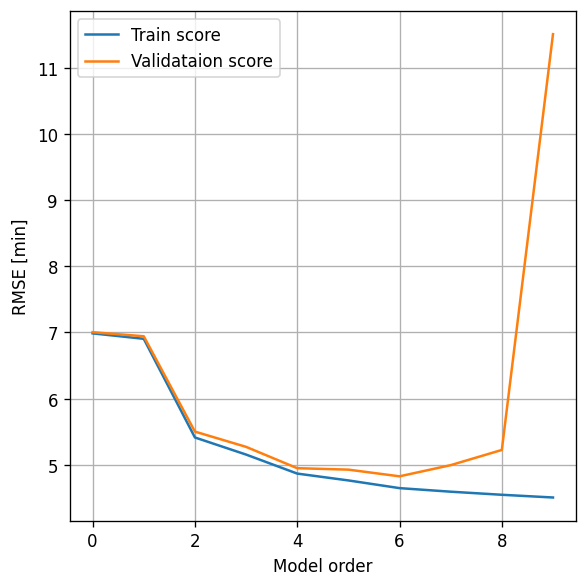

In [ ]:
## Ploting
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(k_list, [train_scores[k] for k in k_list], label='Train score')
ax.plot(k_list, [val_scores[k] for k in k_list], label='Validataion score')
ax.set_xlabel('Model order')
ax.set_ylabel('RMSE [min]')
# ax.set_ylim(5, 6)
plt.tight_layout()
ax.legend();
fig.savefig('./output/taxis_selecting_order.png', dpi=240)

#### Selecting the order

In [ ]:
best_k = min(k_list, key=val_scores.get)
display(Markdown(f'the optimal order is {best_k}'))

the optimal order is 6

### Retrain the model

In [ ]:
aug_func = lambda dataset: aug_func_by_order(dataset, 5)
h, _ = train_linear(train_set, aug_func)
train_score = eval_model_rmse(h, train_set)
display(Markdown(f'The train score of the model is: {train_score:.2f} [min]'))

test_score = eval_model_rmse(h, test_set)
display(Markdown(f'The test score of the model is: {test_score:.2f} [min]'))

The train score of the model is: 4.79 [min]

The test score of the model is: 4.81 [min]

## Regularization

### Ridge

In [ ]:
from sklearn.linear_model import Ridge

def train_ridge(dataset, aug_func):
    x = aug_func(dataset)
    y = dataset['duration'].values
    reg = Ridge(alpha=1e-2, fit_intercept=True, normalize=True, max_iter=1e4)
    reg.fit(x, y)
    theta = reg.coef_
    h = lambda dataset_: reg.predict(aug_func(dataset_))
    return h, theta

In [ ]:
aug_func = lambda dataset: aug_func_by_order(dataset, 9)
h, theta = train_ridge(train_set, aug_func)
train_score = eval_model_rmse(h, train_set)
display(Markdown(f'The train score of the model is: {train_score:.2f} [min]'))

test_score = eval_model_rmse(h, test_set)
display(Markdown(f'The test score of the model is: {test_score:.2f} [min]'))

display(Markdown(f'The number of non zero parameters is {(theta > 1e-5).sum()}'))

The train score of the model is: 4.82 [min]

The test score of the model is: 4.85 [min]

The number of non zero parameters is 196

### LASSO

In [ ]:
# from sklearn.linear_model import Lasso

# def train_lasso(dataset, aug_func):
#     x = aug_func(dataset)
#     y = dataset['duration'].values
#     reg = Lasso(alpha=1e-5, fit_intercept=True, normalize=True, max_iter=1e4)
#     reg.fit(x, y)
#     theta = reg.coef_
#     h = lambda dataset_: reg.predict(aug_func(dataset_))
#     return h, theta

In [ ]:
# aug_func = lambda dataset: aug_func_by_order(dataset, 10)
# h, theta = train_lasso(train_set, aug_func)
# train_score = eval_model_rmse(h, train_set)
# display(Markdown(f'The train score of the model is: {train_score:.2f} [min]'))

# test_score = eval_model_rmse(h, test_set)
# display(Markdown(f'The test score of the model is: {test_score:.2f} [min]'))

# display(Markdown(f'The number of non zero parameters is {(theta > 1e-5).sum()}'))